# HW_07 Бондаренко Алексей bondaleksey@gmail.com

In [1]:
import pandas as pd
import gzip
import json
import numpy as np
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import mean_absolute_error,r2_score

Цель данной работы: сравнить модели User-based и Item-based рекомендаций (collaborative filtering) для задачи предложения пользователям новые покупки. 

Сравниваются эти два метода, так как полагаем, что у нас есть информация только о том, что уже пользователи приобретали в данном магазине и другой информации нет. 

# 1 Данные

## 1.1 Описание данных
 Признаки [набора данных](https://nijianmo.github.io/amazon/index.html)

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- vote - helpful votes of the review
- style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
- image - images that users post after they have received the product

In [2]:
### load the meta data
data = []
with gzip.open('data_rs/Software_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

12805


In [3]:
df = pd.DataFrame.from_dict(data)
print(len(df))

12805


In [48]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4.0,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5.0,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5.0,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5.0,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN


## 1.2 EDA

Число уникальных пользователей

In [5]:
len(pd.unique(df['reviewerID']))

1826

Число уникальных товаров

In [6]:
len(pd.unique(df['asin']))

802

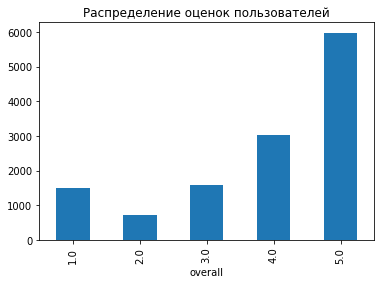

In [55]:
df.value_counts("overall", sort = False).plot(kind = 'bar',title='Распределение оценок пользователей');

Количество отсутствующих значений

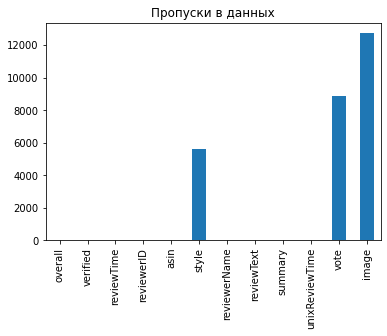

In [64]:
df.isna().sum().plot.bar(title="Пропуски в данных");

Построим распределение пользователей и числа их покупок

In [40]:
reviewers = df[['reviewerID','overall']].groupby('reviewerID').mean().copy()
reviewers['asin_count']=df[['reviewerID','asin']].groupby('reviewerID').size()
reviewers.columns = ['avg_rating', 'number_of_ratings']
reviewers.head()


,avg_rating,number_of_ratings
reviewerID,,
A100UD67AHFODS,4.800000,5
A105S56ODHGJEK,3.689655,29
A1075X1Q4M3S78,5.000000,5
A10C5CJK1YKGV0,4.100000,10
A10CRW7XRJBJ2G,3.200000,5


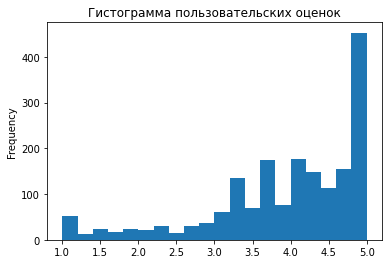

In [61]:
reviewers['avg_rating'].plot.hist(bins=20,title='Гистограмма пользовательских оценок');

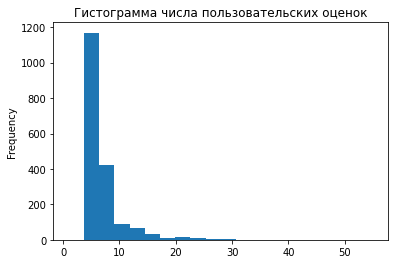

In [62]:
reviewers["number_of_ratings"].plot.hist(bins=20,title='Гистограмма числа пользовательских оценок');

можно и скатерплот число покупок пользователя и его средняя оценка

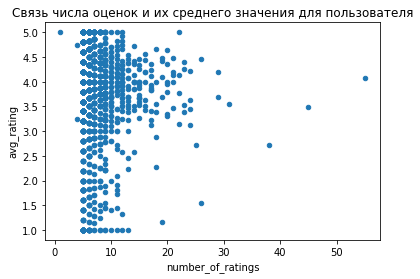

In [43]:
reviewers.plot.scatter(x='number_of_ratings',y='avg_rating',title='Связь числа оценок и их среднего значения для пользователя');

In [12]:
reviewers.head()

,overall,asin_count
reviewerID,,
A100UD67AHFODS,4.800000,5
A105S56ODHGJEK,3.689655,29
A1075X1Q4M3S78,5.000000,5
A10C5CJK1YKGV0,4.100000,10
A10CRW7XRJBJ2G,3.200000,5


In [13]:
ratings = df[['reviewerID','asin','overall','unixReviewTime']].copy()
ratings.head()

,reviewerID,asin,overall,unixReviewTime
0,A38NELQT98S4H8,0321719816,4.0,1287532800
1,A3QJU4FEN8PQSZ,0321719816,4.0,1287360000
2,ACJT8MUC0LRF0,0321719816,5.0,1287187200
3,AYUF7YETYOLNX,0321719816,5.0,1286841600
4,A31ICLWQ9CSHRS,0321719816,5.0,1286409600


# 2 Разбиение данных 

In [14]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

def train_test_split(X, ratio=0.2, user_col='reviewerID', item_col='asin',
                     rating_col='overall', time_col='unixReviewTime'):
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)
    # список всех юзеров
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []
    for userId in tqdm(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(ratings)

  0%|          | 0/1826 [00:00<?, ?it/s]

In [16]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((9705, 2), 9705, (3100, 2), 3100)

In [17]:
X_train.head()

,reviewerID,asin
0,A2G0O4Y8QE10AE,B00004TYCR
1,A2G0O4Y8QE10AE,B0017I8NQM
2,A2G0O4Y8QE10AE,B0017I8NQM
3,A2G0O4Y8QE10AE,B0014KJ6EQ
4,ARXU3FESTWMJJ,B00003JAU7


# 3 Рассмотрим User-based model

In [18]:
class UserBased(BaseEstimator):
    def fit(self, X, y, user_col='reviewerID', item_col='asin'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку пользователя
        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        
        # создаём векторы для каждого пользователя из просмотренных фильмов
        # для неизвестных фильмов ставим оценку 0
        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        
        # считаем попарную схожесть между юзерами
        self.user_sim = cosine_similarity(self.user_ratings)
        
        # также сделаем словарь - {значение user_col: index в user_ratings}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
                
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.user_sim[self.user_pos[pr_user]]).sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator
    
    def predict_rating_avg(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            if pr_user in self.users:
                return self.mean_y_user[pr_user]
            elif pr_item in self.items:
                return self.mean_y_item[pr_item]
            else:
                return 0
                
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.user_sim[self.user_pos[pr_user]]).sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator
    
    def predict(self, X, user_col='reviewerID', item_col='asin'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y
    
    def predict_avg(self, X, user_col='reviewerID', item_col='asin'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating_avg(row[0], row[1]), axis=1)
        return y


In [19]:
results = []

In [20]:
%%time
print('start fitting...')
ub = UserBased().fit(X_train, y_train)
y_ub_pred = ub.predict(X_test)
y_ub_pred_avg = ub.predict_avg(X_test)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, y_ub_pred)))
print('for avg+ rmse = {}'.format(rmse(y_test, y_ub_pred_avg)))

start fitting...
start predicting...
rmse = 1.317262409587942
for avg+ rmse = 1.1211117676301765
CPU times: total: 1.3 s
Wall time: 1.17 s


In [21]:
errors={'User-based model':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ub_pred),
        "Mean absolute error":mean_absolute_error(y_test, y_ub_pred),
        "Mean squared error":mean_squared_error(y_test, y_ub_pred,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ub_pred,squared=False),
        "R2": r2_score(y_test, y_ub_pred)
        }}
results.append(errors)
errors={'User-based model avg+':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ub_pred_avg),
        "Mean absolute error":mean_absolute_error(y_test, y_ub_pred_avg),
        "Mean squared error":mean_squared_error(y_test, y_ub_pred_avg,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ub_pred_avg,squared=False),
        "R2": r2_score(y_test, y_ub_pred_avg)
        }}
results.append(errors)

# 4 Рассмотрим Item-based model

In [22]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='reviewerID', item_col='asin'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого фильма с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между фильмами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict_rating_avg(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            if pr_user in self.users:
                return self.mean_y_user[pr_user]
            elif pr_item in self.items:
                return self.mean_y_item[pr_item]
            else:
                return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict(self, X, user_col='reviewerID', item_col='asin'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y
    
    def predict_avg(self, X, user_col='reviewerID', item_col='asin'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating_avg(row[0], row[1]), axis=1)
        return y

In [23]:
%%time
print('start fitting...')
ib = ItemBased().fit(X_train, y_train)
print('start predicting...')
y_ib_pred = ib.predict(X_test)
y_ib_pred_avg = ib.predict_avg(X_test)
print('rmse = {}'.format(rmse(y_test, y_ib_pred)))
print('for avg+ rmse = {}'.format(rmse(y_test, y_ib_pred_avg)))


start fitting...
start predicting...
rmse = 1.470201060696142
for avg+ rmse = 1.2973829421868814
CPU times: total: 1.25 s
Wall time: 1.27 s


In [24]:
errors={'Item-based model':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ib_pred),
        "Mean absolute error":mean_absolute_error(y_test, y_ib_pred),
        "Mean squared error":mean_squared_error(y_test, y_ib_pred,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ib_pred,squared=False),
        "R2": r2_score(y_test, y_ib_pred)
        }}
results.append(errors)
errors={'Item-based model avg+':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ib_pred_avg),
        "Mean absolute error":mean_absolute_error(y_test, y_ib_pred_avg),
        "Mean squared error":mean_squared_error(y_test, y_ib_pred_avg,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ib_pred_avg,squared=False),
        "R2": r2_score(y_test, y_ib_pred_avg)
        }}
results.append(errors)

# 5 Сравнение рекомендаций моделей 

In [25]:
otputdf = pd.DataFrame.from_dict(results[0], orient= 'index')
for item in results[1:]:
    otputdf = pd.concat([otputdf, pd.DataFrame.from_dict(item, orient= 'index')],axis=0)
# otputdf = otputdf.drop('R2',axis=1)
otputdf.columns = ['MAPE','MAE','MSE','RMSE','R2']

In [26]:
otputdf

,MAPE,MAE,MSE,RMSE,R2
User-based model,0.359581,0.864186,1.735180,1.317262,0.056402
User-based model avg+,0.340037,0.770855,1.256892,1.121112,0.316497
Item-based model,0.491447,1.058052,2.161491,1.470201,-0.175427
Item-based model avg+,0.471904,0.964721,1.683202,1.297383,0.084668


# Заключение 
Сравнение между методами основанным на пользователях и товарах на данном наборе данных, выигрывает подход основанный на пользователях, так как число уникальных пользователей почти в 2 раза превышает число товаров. 

Отметим, что если для холодного запуска (когда у нас нет информации о пользователе или товаре), добавить возврат средней оценку пользователя или средней оценки предмета, то получим прирост в качестве.
Данная добавка видна в оценках User-based model avg+ и Item-based model avg+